## *What is computer vision?*
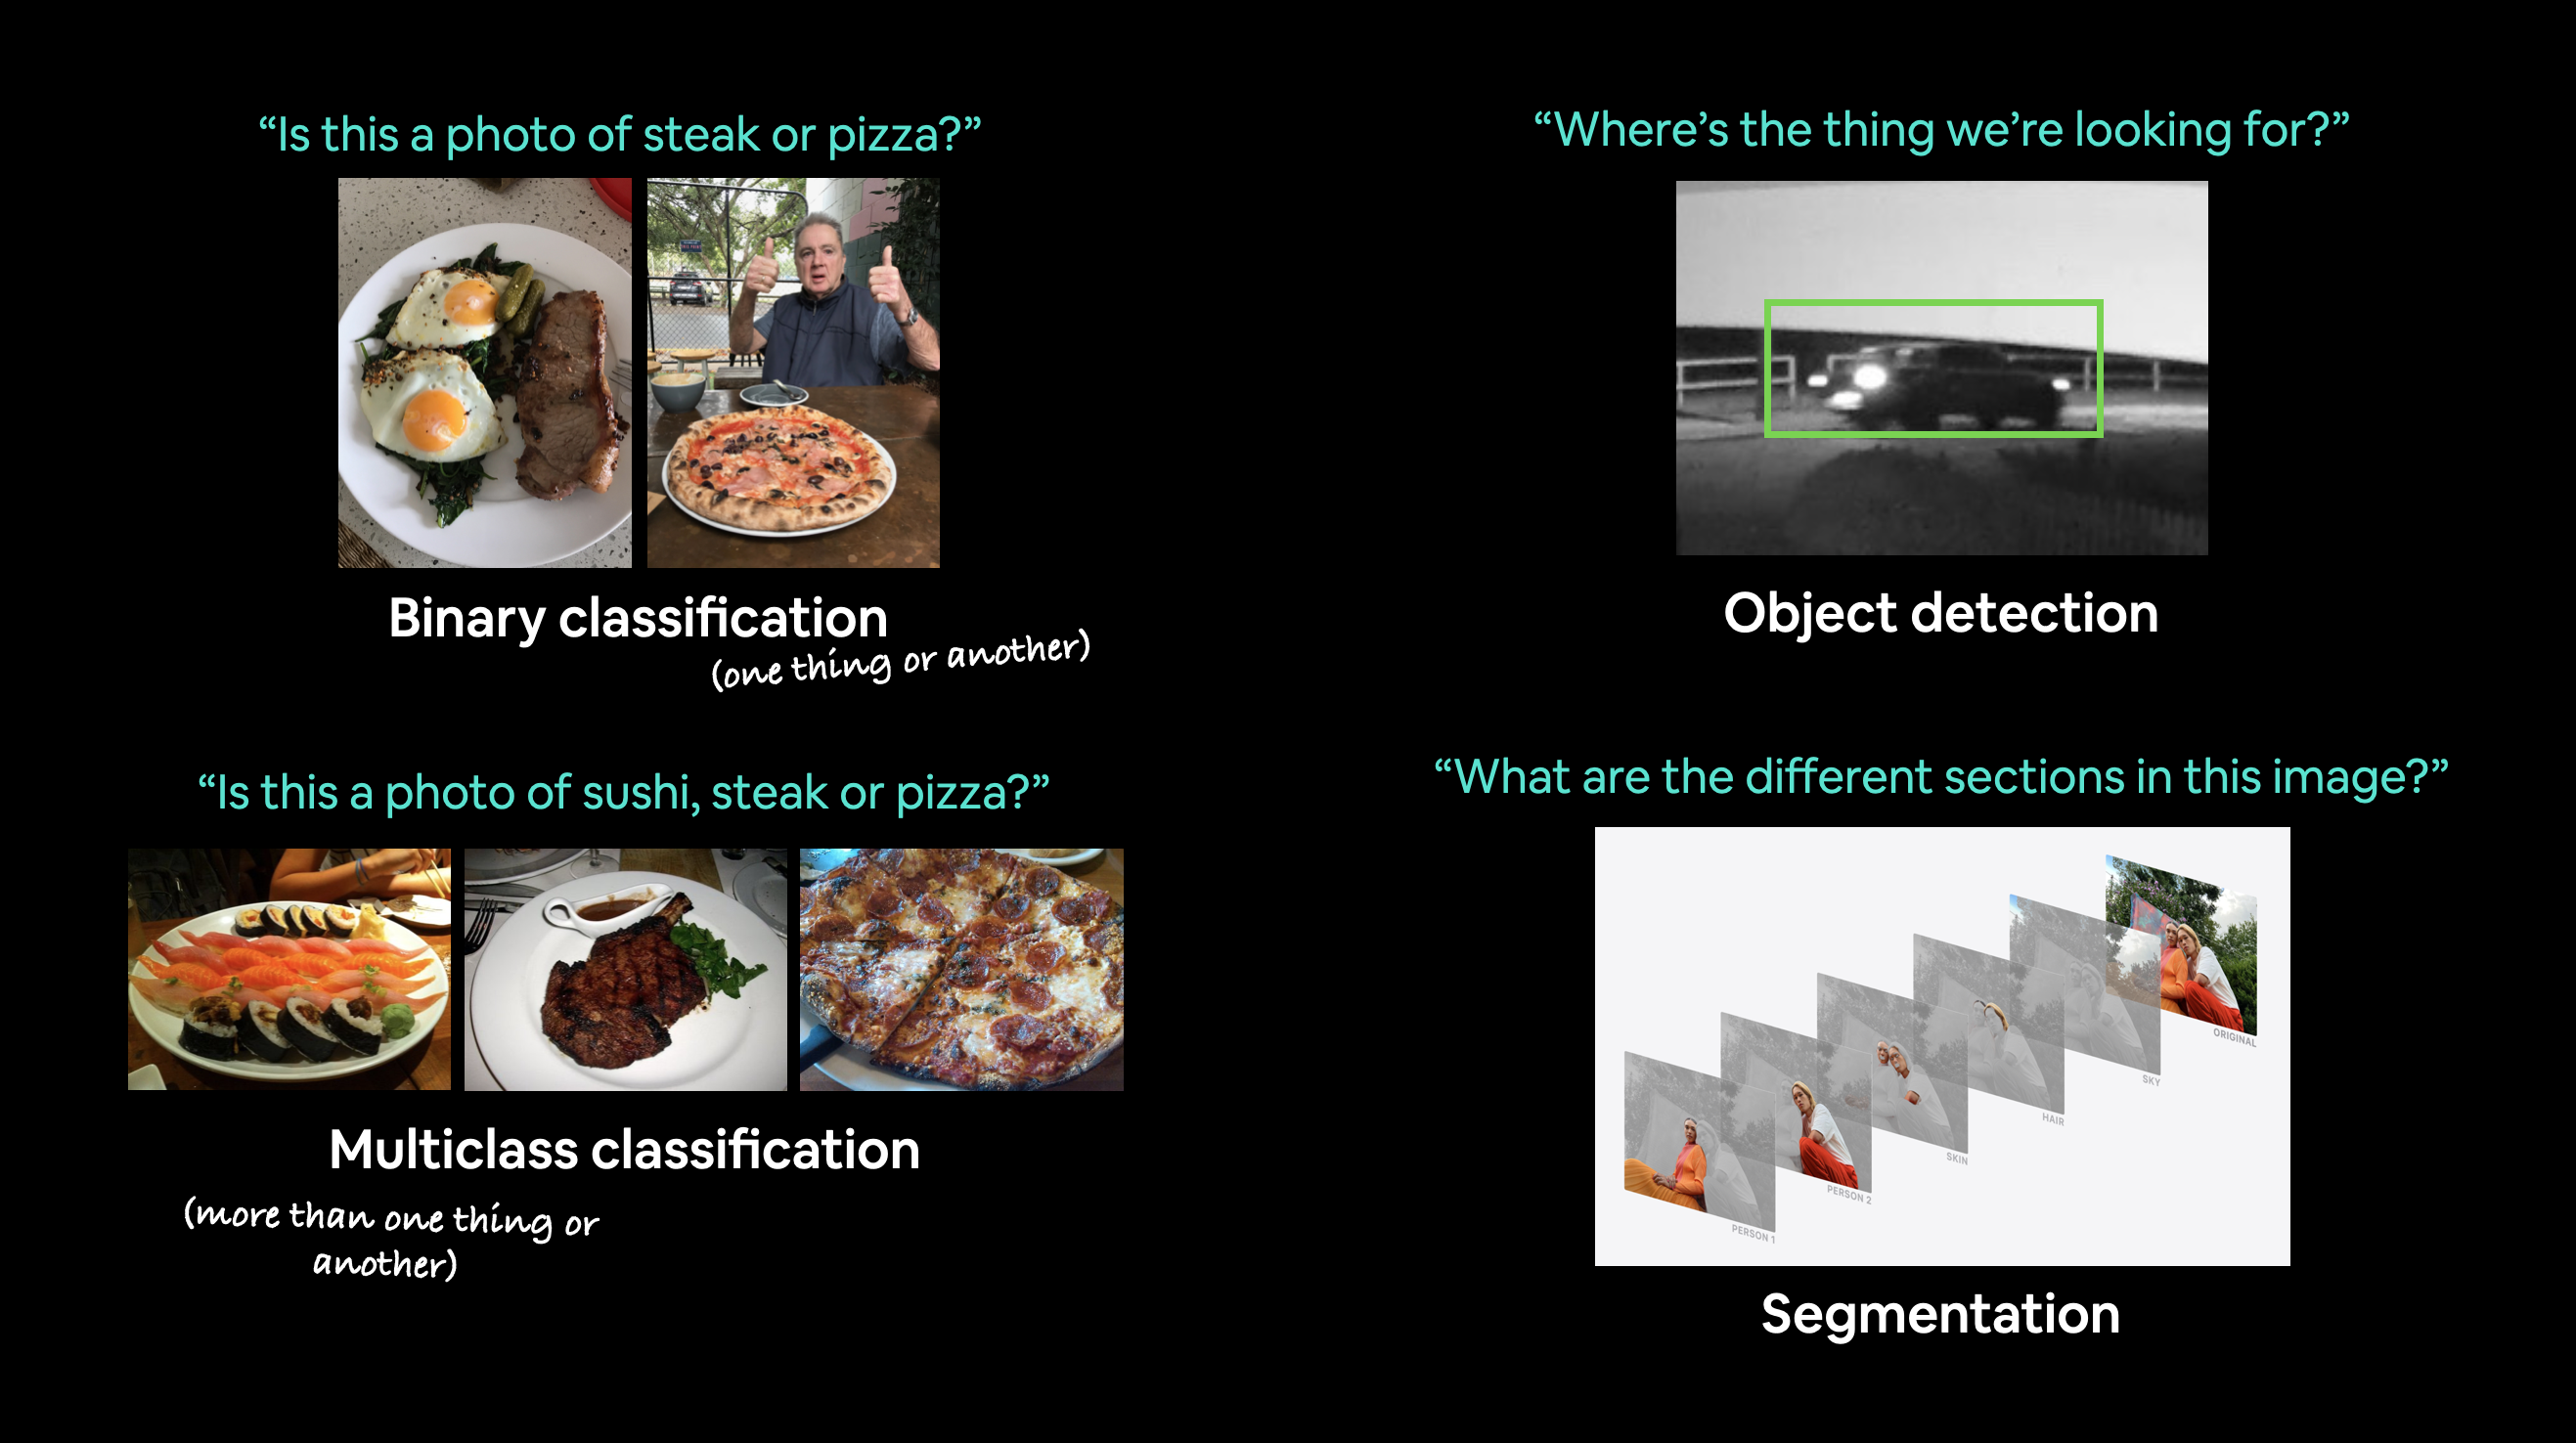

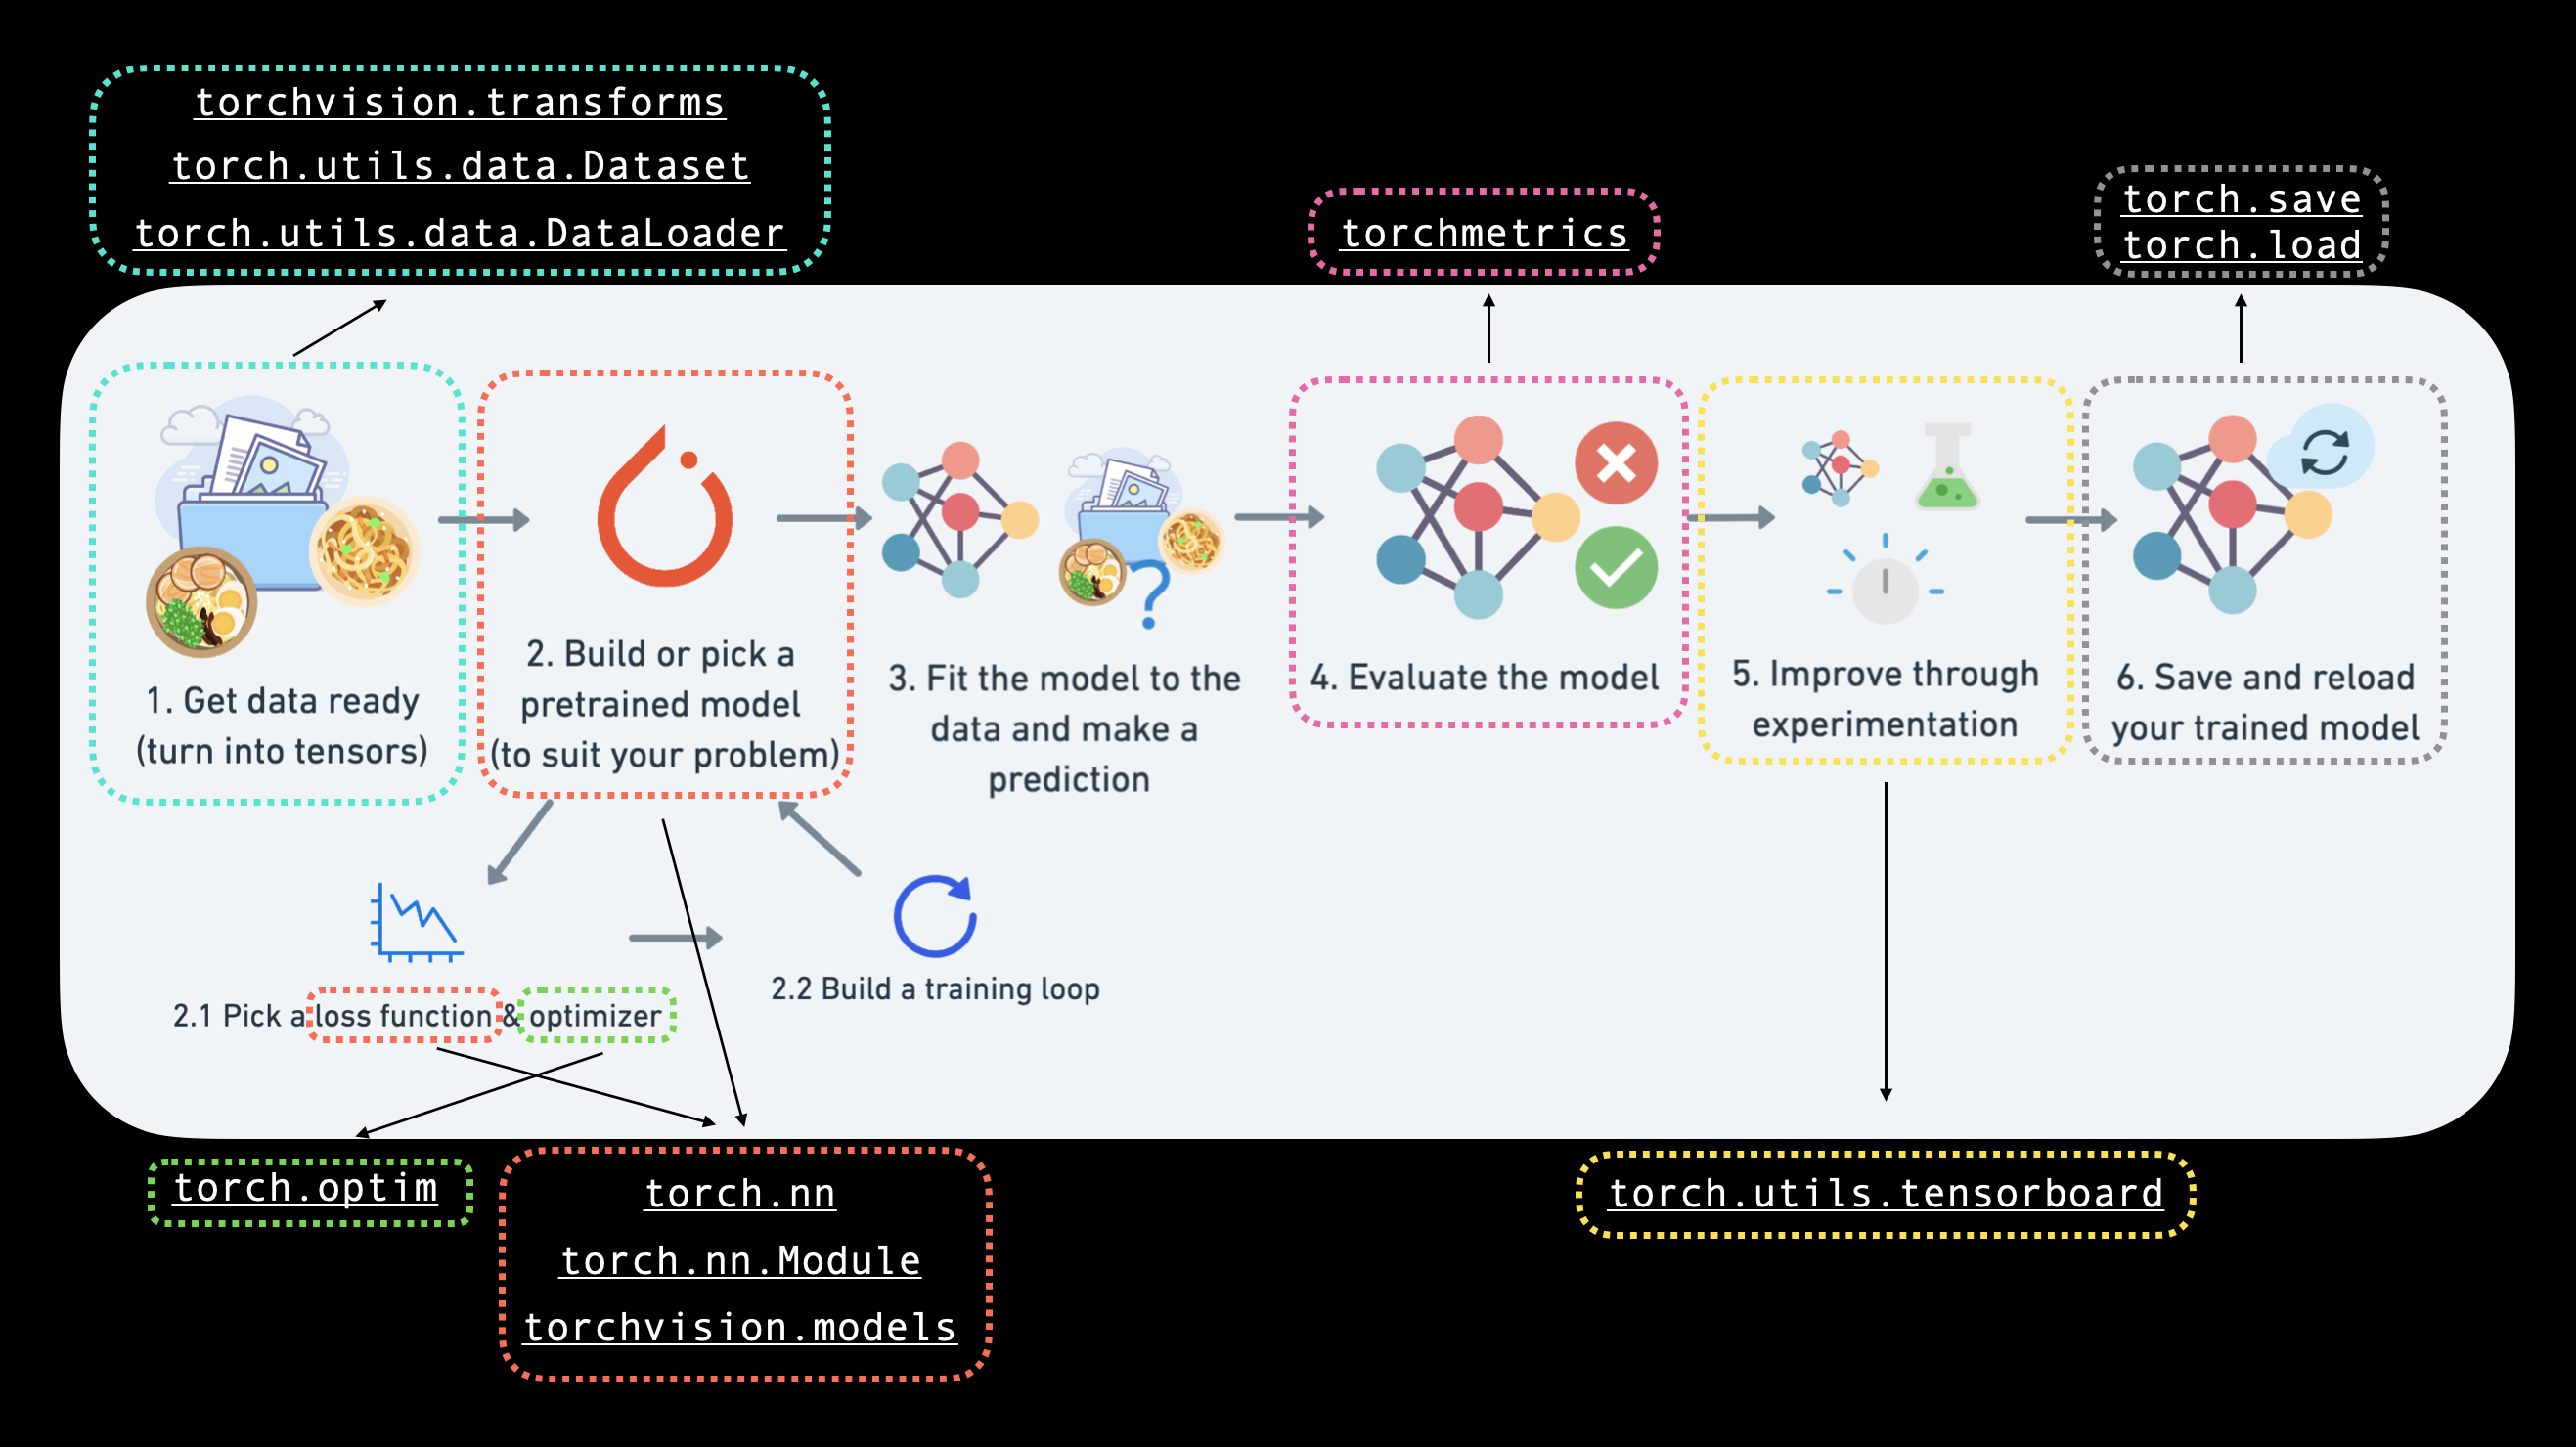

## *Computer vision libraries in PyTorch*

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets

from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
print('torch version:',torch.__version__,'\ntorchvision version:',torchvision.__version__)

## *Getting a dataset*
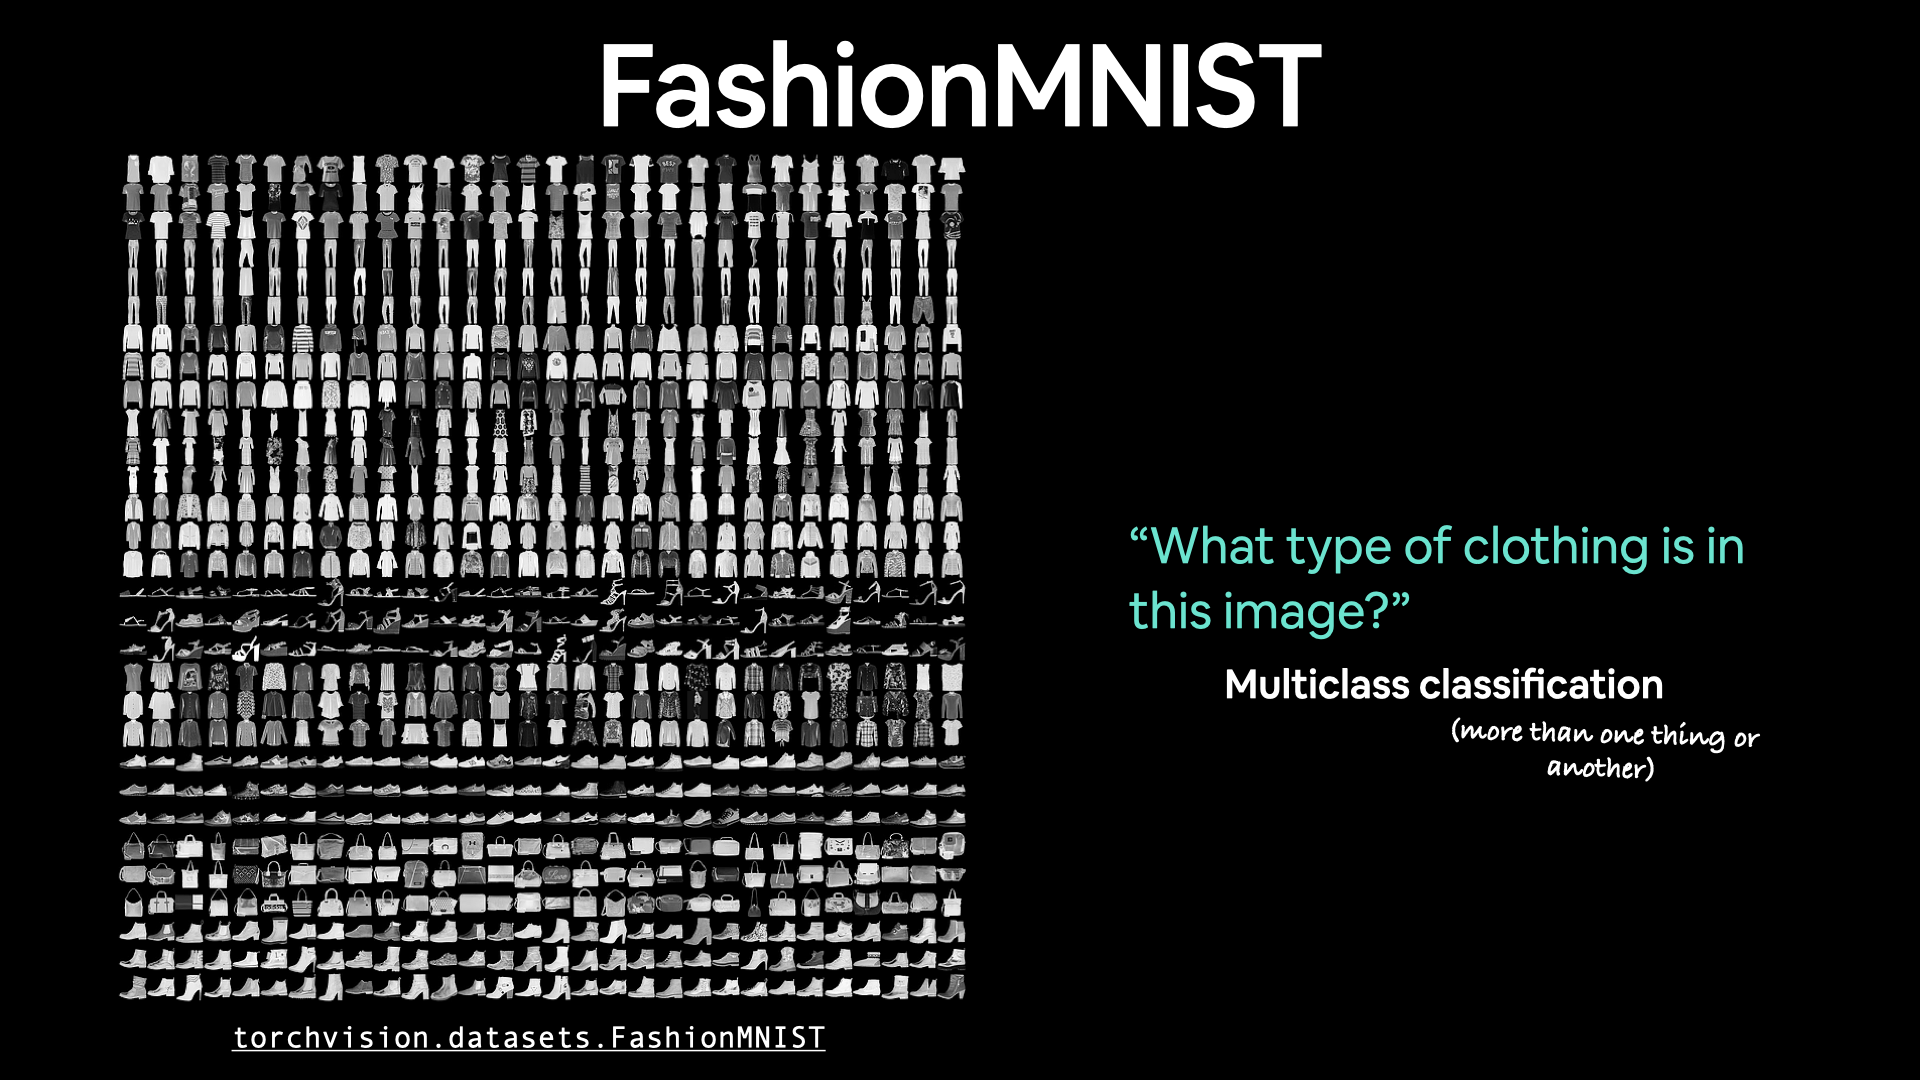


In [ ]:
train_data = datasets.FashionMNIST(
    root= 'data',
    train= True,
    download= True,
    transform= ToTensor(),
    target_transform= None
)


test_data = datasets.FashionMNIST(
    
    root= 'data',
    train= False,
    download= True,
    transform= ToTensor()

)

In [ ]:
image, label = train_data[60000-1]
print(image, label)
print('Shape of an image:',image.shape)
print('train_data label:',train_data.targets, '\ntest_data label:', test_data.targets)

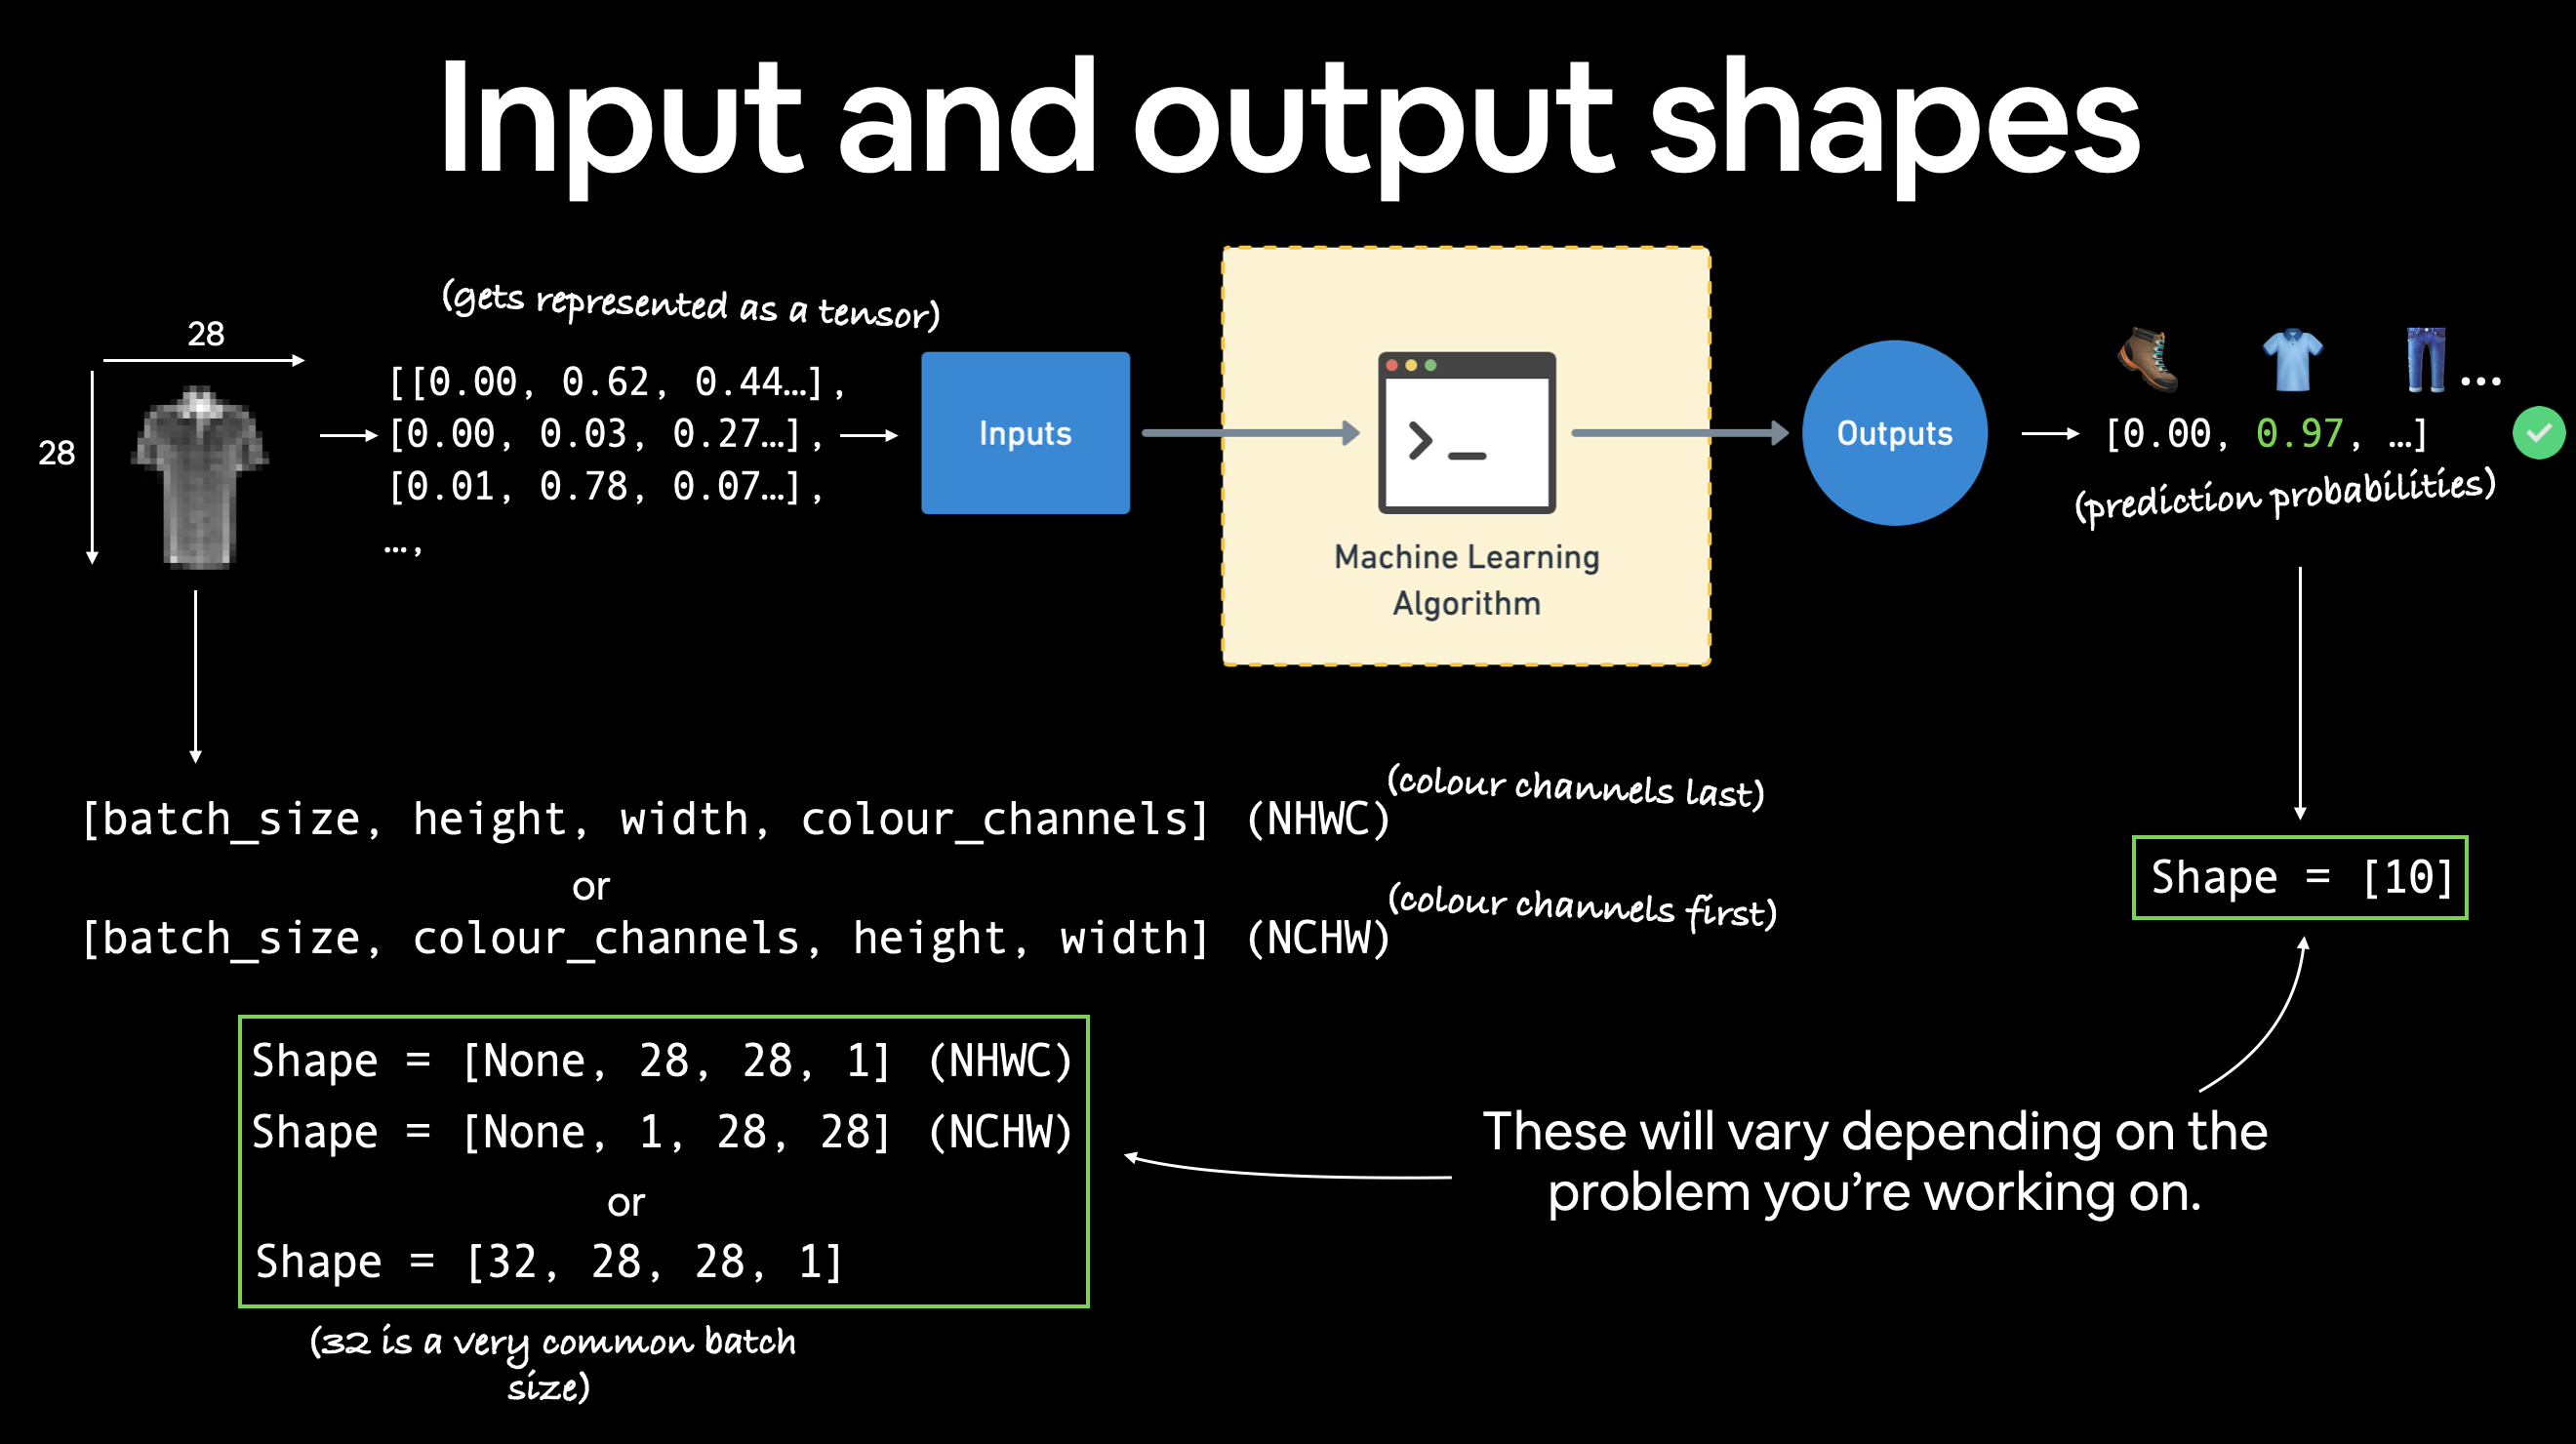

In [ ]:
len(train_data.data), len(test_data.data), len(train_data.targets), len(test_data.targets)

In [ ]:
class_names = train_data.classes

print(class_names)
class_names[9]

## *Visualizing our data*

In [ ]:
image, label= train_data[60000-1]
plt.imshow(image.squeeze())
print(class_names[label])
plt.axis('off')
print('Image_shape:', image.shape)

In [ ]:
image, label= train_data[60000-1]
plt.imshow(image.squeeze(), cmap= 'gray')
print(class_names[label])
plt.axis('off')
print('Image_shape:', image.shape)

In [ ]:
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4

for i in range(1, rows * cols +1):

  random_idx = torch.randint(0, len(train_data), size= [1]).item()
  image, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze())
  plt.axis('off')
  plt.title(class_names[label])

## *Prepare dataloader*

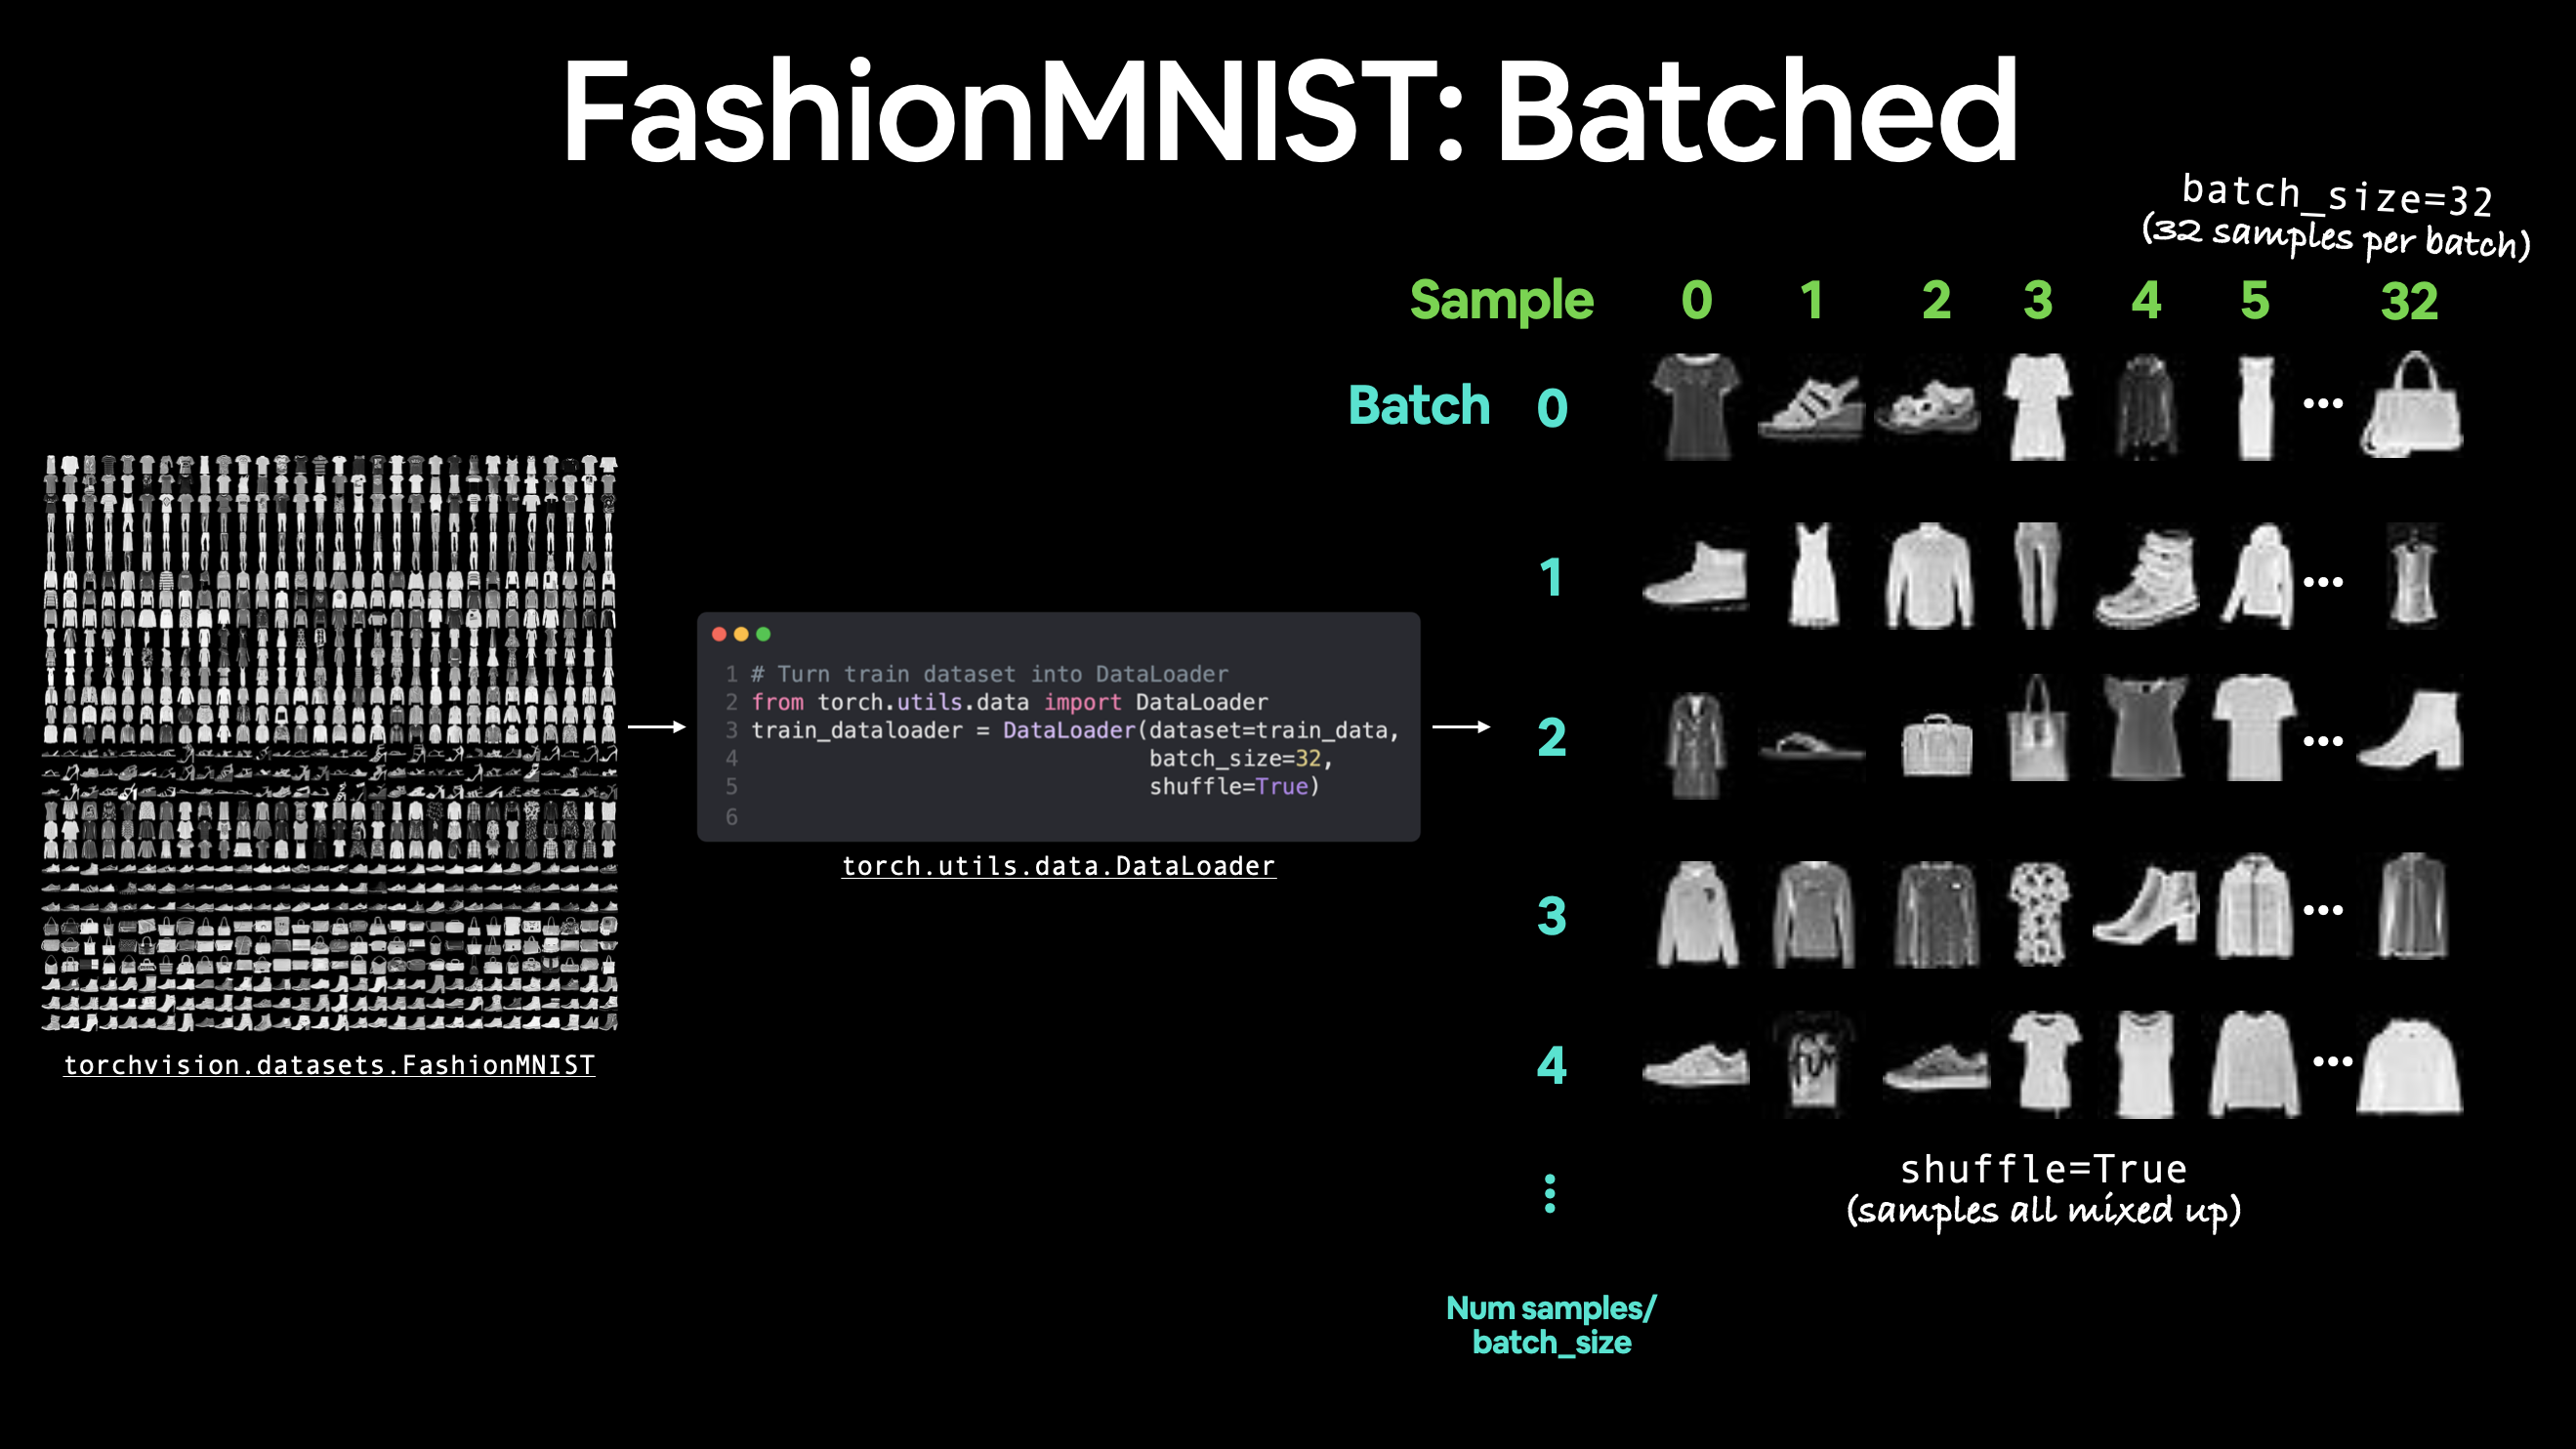

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE= 32

train_dataloader= DataLoader(train_data, batch_size=BATCH_SIZE, shuffle= True)
test_dataloader= DataLoader(test_data, batch_size=BATCH_SIZE, shuffle= False)
print(f"dataloaders:{train_dataloader, test_dataloader}")
print(f"No of batches in test dataloader:{len(test_dataloader)}")
print(f"No of batches in train dataloader:{len(train_dataloader)}")


In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape, train_labels_batch, train_labels_batch.shape)

In [ ]:
#torch.manual_seed(22)
random_idx= torch.randint(0, len(train_features_batch),size=[1]).item()
img, label= train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze())
plt.title(class_names[label])
plt.axis('off')
print(f"Image shape:{img.shape}")
print(f"Label:{label}")




## *Model0: Build a baseline model*

In [ ]:

flatten_model= nn.Flatten()
x= train_features_batch[0]
output = flatten_model(x)
print(f"model input:{x.shape}")
print(f"model output:{output.shape}")

In [ ]:
from torch import nn
class FashionMNISTmodelv0(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()
    self.layer_stack= (nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= input_shape, out_features= hidden_units),
        nn.Linear(in_features= hidden_units, out_features= output_shape)
        ))
    

  def forward(self, x):
      return self.layer_stack(x)



In [ ]:
model0= FashionMNISTmodelv0(input_shape=784, hidden_units= 10, output_shape= len(class_names))
model0.to('cpu')

## *Setup loss, optimizer and evaluation metrics*

In [ ]:
import pathlib
from pathlib import Path
import requests

if Path("helper_functions.py").is_file():
  print('helper_functions.py already exists, skipping download.')
else:
  print('Ready to download helper_functions.py.')
  request= requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


In [ ]:
from helper_functions import accuracy_fn
loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(params= model0.parameters(), lr= 0.1)

## *Creating a function to time our experiments*

In [ ]:
from timeit import default_timer as timer
def print_train_time(start:float, end:float, device: torch.device=None):
  total_time= end - start
  print(f"train time on {device}:{total_time:.3f} seconds")
  return total_time


## *Creating a training loop and training a model on batches of data*

In [ ]:
from tqdm.auto import tqdm
epochs= 3
train_time_start_on_cpu= timer()

for epoch in tqdm(range(epochs)):

  train_loss= 0
  for batch, (X,y) in enumerate(train_dataloader):
    
    model0.train()
    y_pred= model0(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch % 400 == 0:
      print(f"we are looking at{batch*len(X)}/{len(train_dataloader.dataset)}")
    
  train_loss/= len(train_dataloader)
  
  test_loss, test_acc= 0, 0
  model0.eval()
  with torch.inference_mode():
    
    for X, y in test_dataloader:
      
      test_pred = model0(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true= y, y_pred = test_pred.argmax(dim=1))
    
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
  print(f"Train Loss:{train_loss:.4f},| Test loss:{test_loss:.4f}, Test accuracy:{test_acc:.4f}")

train_time_end_on_cpu= timer()

total_train_time_model0= print_train_time(start= train_time_start_on_cpu, end= train_time_end_on_cpu, device= str(next(model0.parameters()).device))

## *Make predictions and get Model 0 results*

In [ ]:
def eval_model(model:torch.nn.Module,dataloader: torch.utils.data.dataloader,loss_fn: torch.nn.Module,accuracy_fn):
  
  model.eval()
  loss, acc= 0, 0
  with torch.inference_mode():
       for X, y in dataloader:
          test_pred= model(X)
          loss += loss_fn(test_pred, y)
          acc += accuracy_fn(y_true=y, y_pred= test_pred.argmax(dim=1))

       loss /= len(dataloader)
       acc /= len(dataloader)

  return {"Model name":model.__class__.__name__,
          "Loss": loss.item(),
          "Accuracy": acc} 
   

evaluate= eval_model(model= model0, dataloader= test_dataloader, loss_fn=loss_fn, accuracy_fn= accuracy_fn)
print(evaluate)





## *Setup device agnostic-code (for using a GPU if there is one)*

In [ ]:
import torch
device= "cuda" if torch.cuda.is_available() else "cpu"
device

## *Model1: Building a better model with non-linearity*

In [ ]:
from torch import nn

class FashionMNISTmodelv1(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()
    self.layer_stack= nn.Sequential(
        
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features= hidden_units, out_features= output_shape),
        nn.ReLU()
    )
  
  
  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [ ]:
model1 = FashionMNISTmodelv1(input_shape=784, hidden_units=20, output_shape= len(class_names)).to(device)
#next(model1.parameters()).device
model1

## *Setup loss, optimizer and evaluation metrics*

In [ ]:
from helper_functions import accuracy_fn
loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(params= model1.parameters(), lr=0.1)


## *Functionizing training and test loops*

In [ ]:
def train_step(model:torch.nn.Module,dataloader:torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer,
               loss_fn:torch.nn.Module,
               accuracy_fn, device:torch.device=device):
  
  train_loss, train_acc= 0, 0
  
  for batch, (X, y) in enumerate(dataloader):

    X, y = X.to(device), y.to(device)

    y_pred= model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred= y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_loss/= len(dataloader)
  train_acc/= len(dataloader)
  print(f"Train Loss: {train_loss:.3f}| Train accuracy:{train_acc:.3f}")

  
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device= device):
  
  test_loss, test_acc= 0, 0
  model.eval()
  with torch.inference_mode():

    for X, y in dataloader:

      X, y= X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
    
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    print(f"Test Loss:{test_loss:.2f}| Test accuracy:{test_acc:.2f}")


In [ ]:
from timeit import default_timer as timer
train_time_start_on_gpu= timer()
epochs= 3

for i in tqdm(range(epochs)):

  print(f"Epoch:{i}\n......")
  train_step(model= model1, dataloader= train_dataloader,loss_fn=loss_fn, accuracy_fn= accuracy_fn, optimizer= optimizer)
  test_step(model= model1, dataloader= test_dataloader, loss_fn=loss_fn, accuracy_fn= accuracy_fn)

train_time_end_on_gpu= timer()

total_train_time_model1 = print_train_time(start= train_time_start_on_gpu, end= train_time_end_on_gpu, device= device)

In [ ]:
def eval_model(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device:torch.device= device):
  loss, acc= 0, 0
  model.eval()

  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true= y, y_pred=y_pred.argmax(dim=1))
    loss /= len(dataloader)
    acc /= len(dataloader)

  return {"model name":model.__class__.__name__,
          "model Loss": loss.item(),
          "model accuracy": acc}


model1_results= eval_model(model= model1, dataloader= test_dataloader, loss_fn= loss_fn, accuracy_fn=accuracy_fn)
model1_results  


In [ ]:
model0_results = eval_model(model= model0, dataloader= test_dataloader, loss_fn= loss_fn, accuracy_fn= accuracy_fn)
model0_results

## *Model 2: Building a Convolutional Neural Network (CNN)*
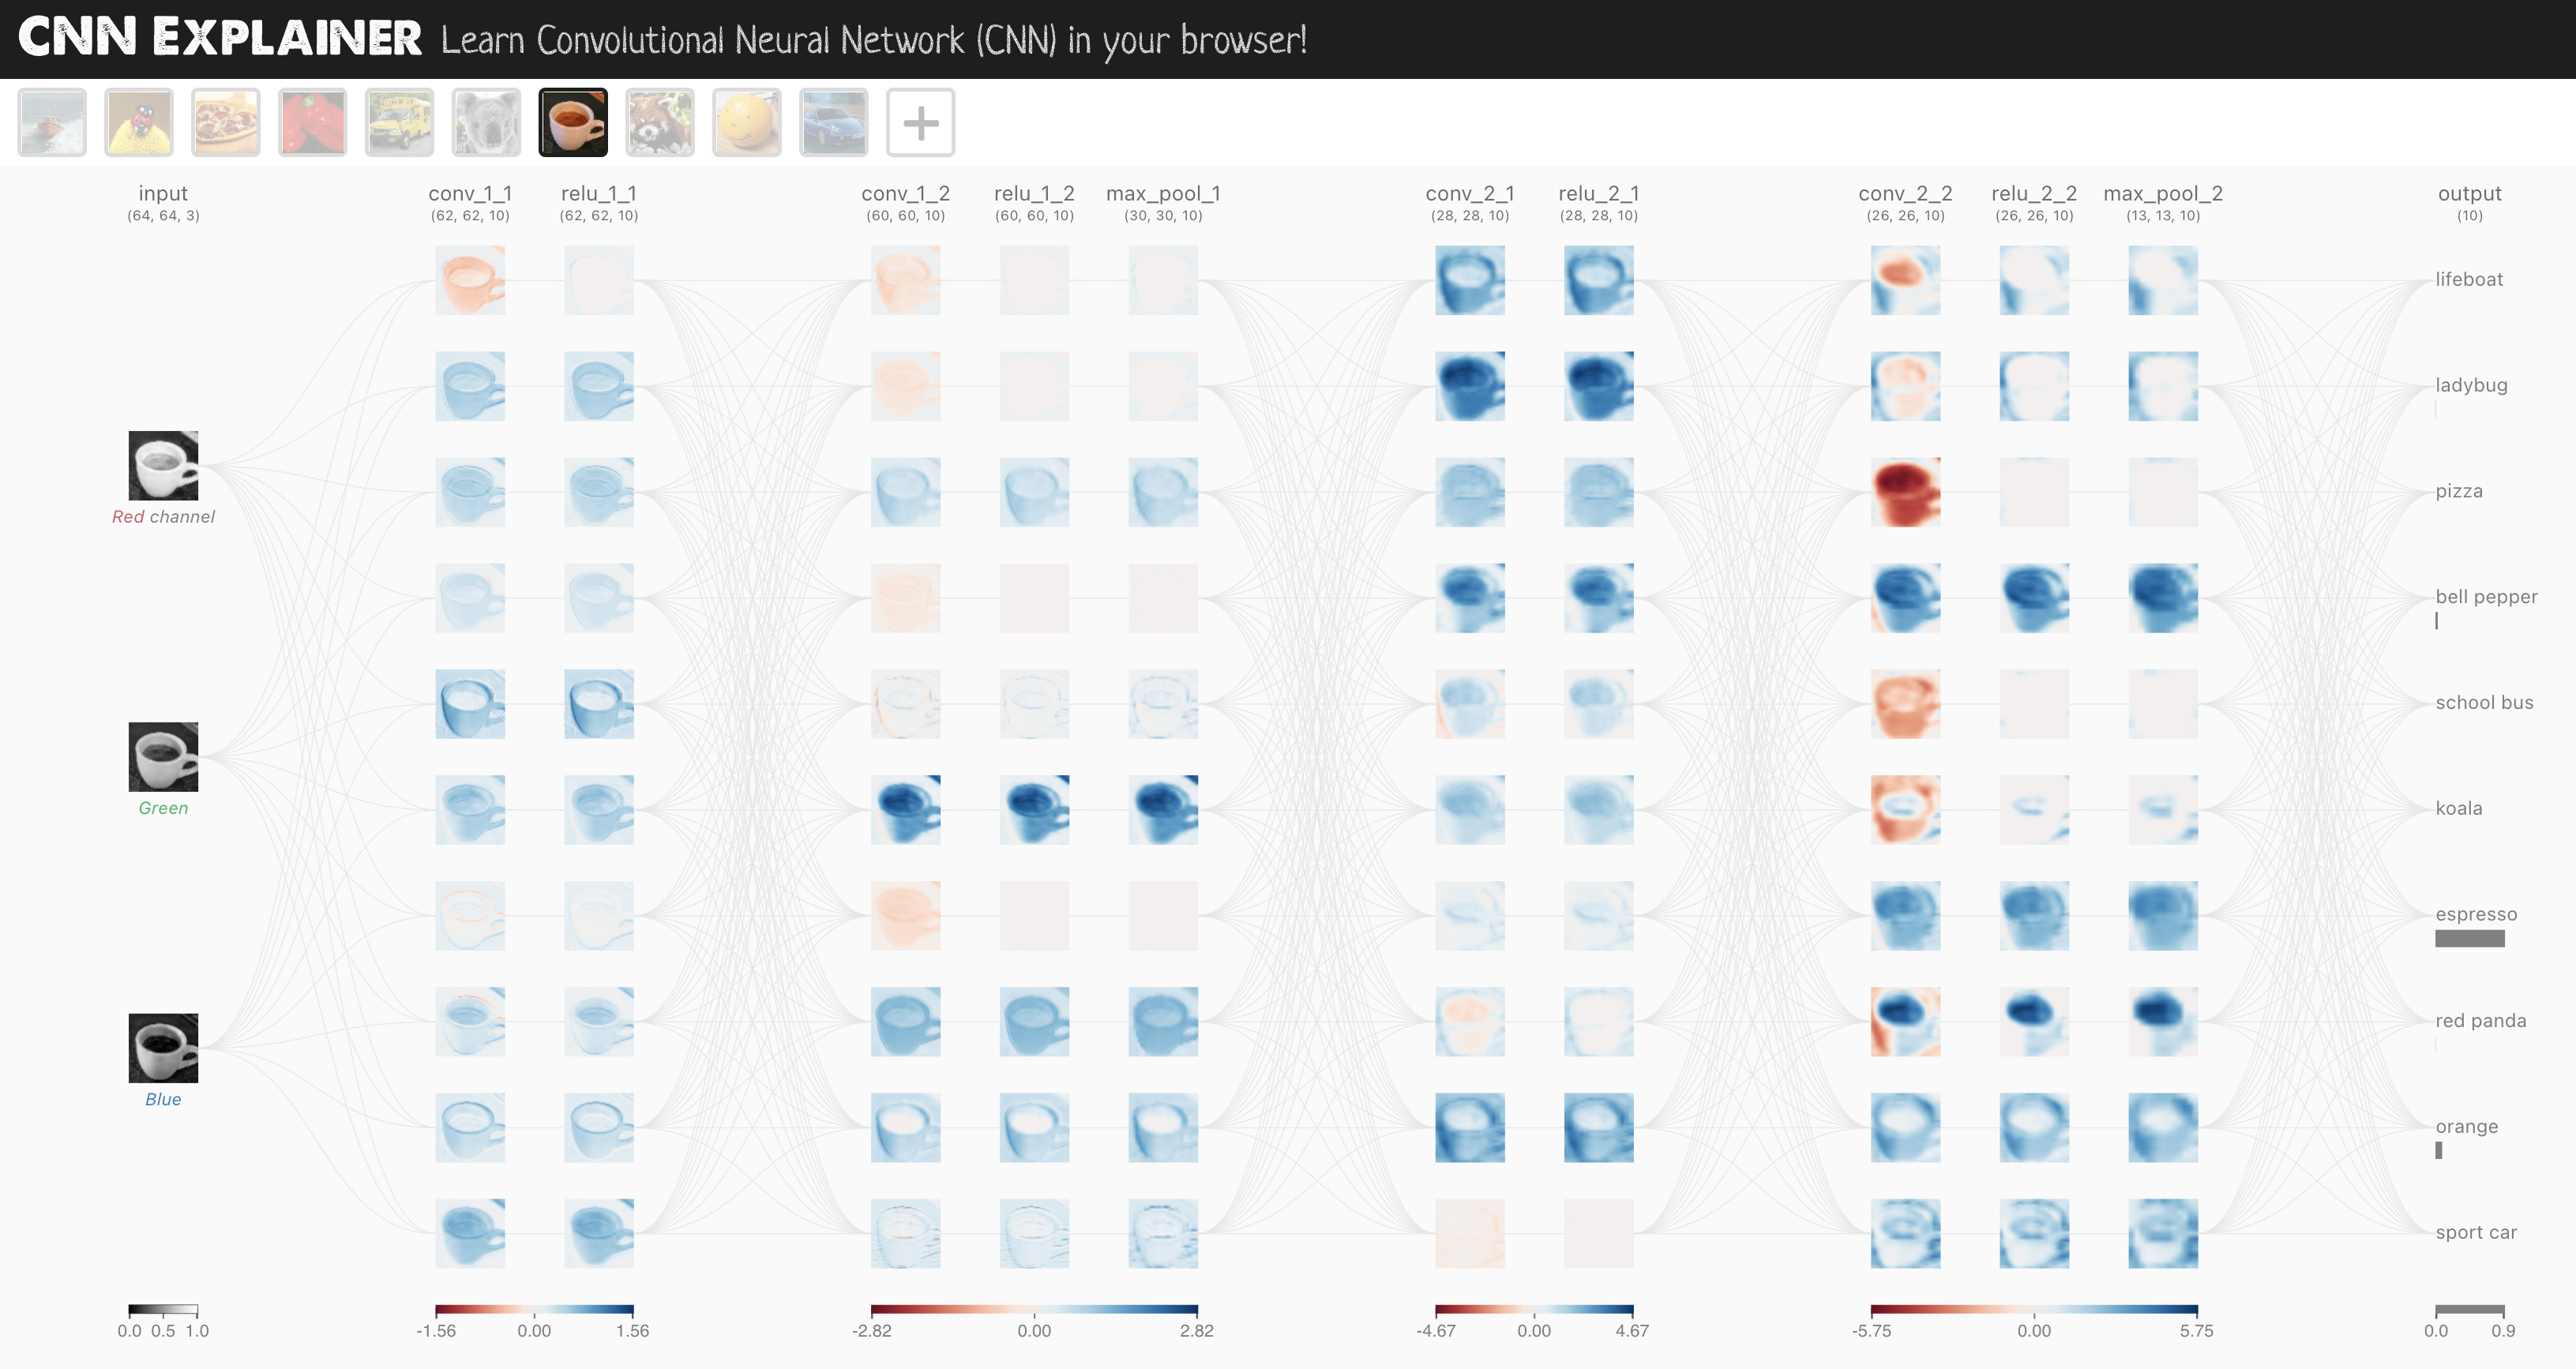

In [ ]:
class FashionMNISTmodelv2(nn.Module):
  def __init__(self, input_shape:int, hidden_units: int, output_shape:int):
    super().__init__()

    self.block1= nn.Sequential(
        nn.Conv2d(in_channels= input_shape, out_channels= hidden_units, kernel_size= 3, padding= 1, stride= 1),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_units, out_channels= hidden_units, kernel_size= 3, padding= 1, stride= 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2, stride= 2)

    )

    self.block2= nn.Sequential(
        nn.Conv2d(in_channels= hidden_units, out_channels= hidden_units, kernel_size= 3, padding= 1, stride= 1),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_units, out_channels= hidden_units, kernel_size= 3, padding= 1, stride= 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2, stride= 2)

    )

    self.classifier= nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= hidden_units*7*7 , out_features= output_shape)
    )


  def forward(self, x:torch.Tensor):
    x = self.block1(x)
    x = self.block2(x)
    x = self.classifier(x)
    return x

torch.manual_seed(22)

model2 = FashionMNISTmodelv2(input_shape= 1, hidden_units= 10, output_shape= len(class_names))

model2




## *Setup a loss function and optimizer for model2*

In [ ]:
from helper_functions import accuracy_fn

loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(params= model2.parameters(), lr= 0.1)

## *Training and testing model2 using our training and test functions*

In [ ]:
torch.manual_seed(20)
train_time_start_gpu= timer()
epochs= 3

for i in tqdm(range(epochs)):

  print(f"Epoch:{i}\n---")
  train_step(model= model2, dataloader= train_dataloader, loss_fn= loss_fn, accuracy_fn= accuracy_fn, optimizer= optimizer, device= device)
  test_step(model= model2, dataloader= test_dataloader, loss_fn= loss_fn, accuracy_fn= accuracy_fn, device= device)

train_time_end_gpu= timer()

total_train_time_model2= print_train_time(start= train_time_start_gpu, end= train_time_end_gpu, device= device)


## *Stepping through nn.Conv2d()*

In [ ]:
images= torch.randn(32, 3, 64, 64)
test_image= images[31]
print(image.shape, test_image.shape)
print(test_image)


## *Understanding hyperparameters with conv2d layer*

In [ ]:

conv_layer= nn.Conv2d(in_channels= 1, out_channels= 10, kernel_size= 3, padding=0, stride= 1)
print(conv_layer(test_image).shape)
print(conv_layer.state_dict())
print("Weight:",conv_layer.weight)
print(f"Bias:{conv_layer.bias}")

In [ ]:
conv_layer= nn.Conv2d(in_channels= 3, out_channels= 15, kernel_size= 3, padding=0, stride= 1)
print(conv_layer(test_image).shape)
print(conv_layer.state_dict())
print("Weight:",conv_layer.weight)
print(f"Bias:{conv_layer.bias}")
print(f"conv weight shape:{conv_layer.weight.shape}")
print(f"conv layer bias shape:{conv_layer.bias.shape}")

## *Stepping through nn.MaxPool2d()*

In [ ]:
print(f"Test image: {test_image.shape}")
test_image_within_conv_layer= conv_layer(test_image)
print(f"Test image within conv:{test_image_within_conv_layer.shape}")
maxpool2d = nn.MaxPool2d(kernel_size= 2)
print(f"Test image within conv and maxpool:{maxpool2d(test_image_within_conv_layer).shape}")


In [ ]:
random_tensor= torch.randn(1,1,2, 2)
print(random_tensor)
print(random_tensor.shape)
maxpool= nn.MaxPool2d(kernel_size=2)
print(maxpool(random_tensor))
print(maxpool(random_tensor).shape)

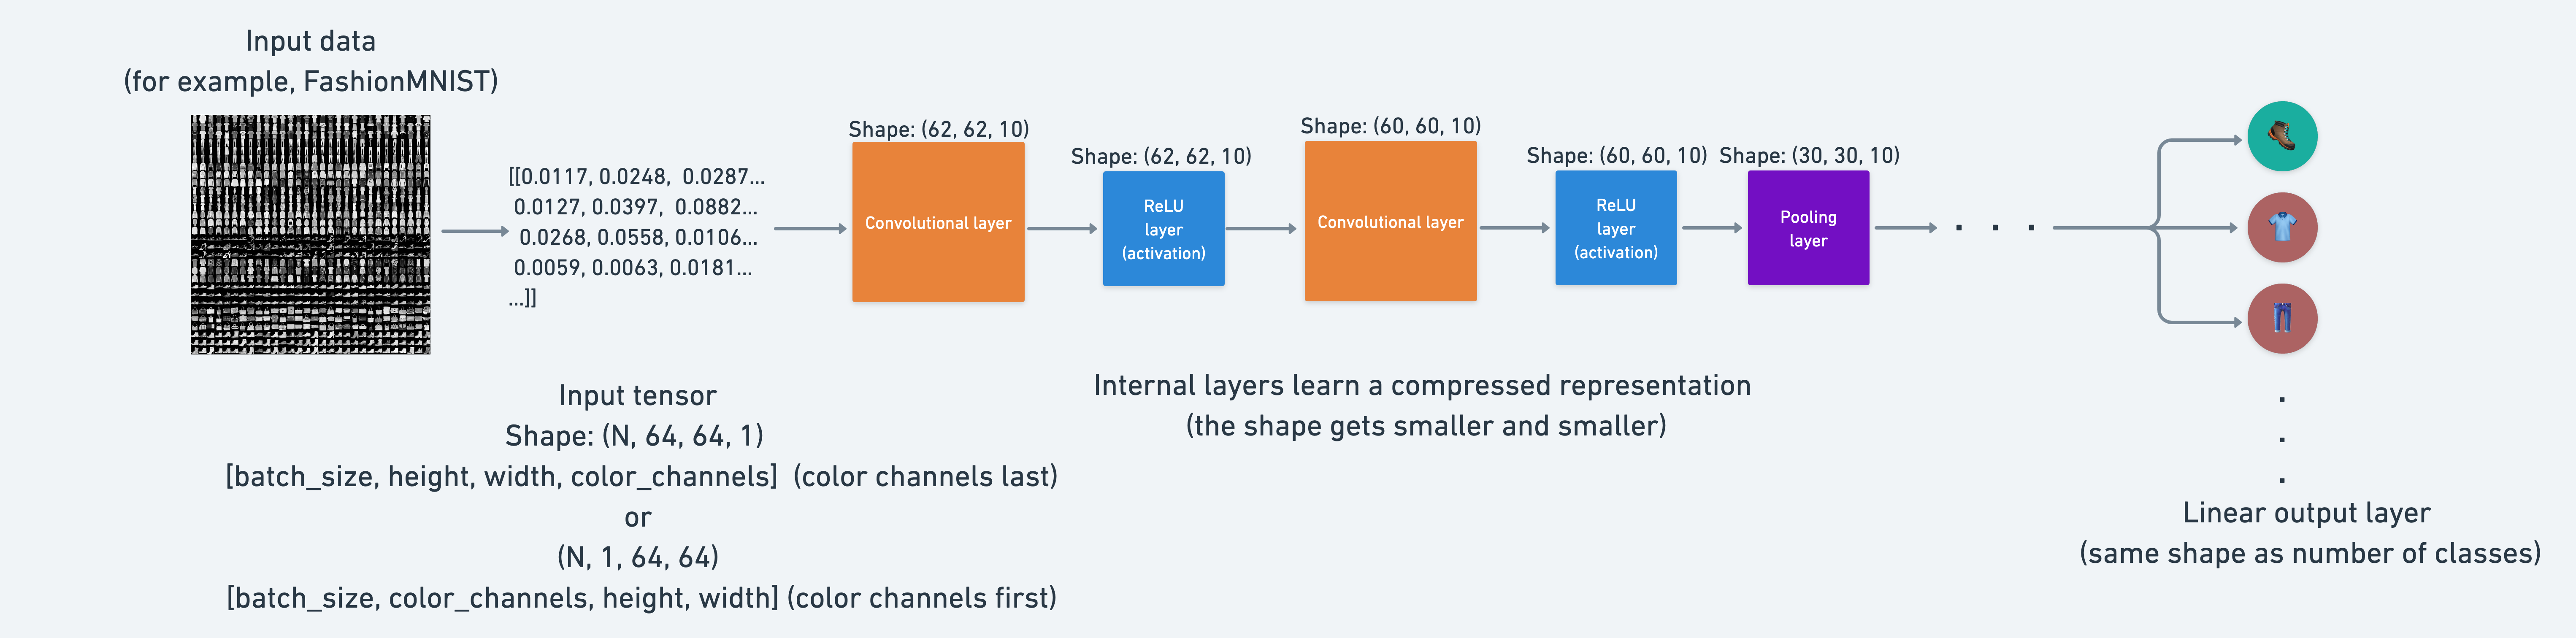

## *Compare model results and training time*

In [ ]:
model2_results= eval_model(model= model2, dataloader= test_dataloader, accuracy_fn= accuracy_fn,loss_fn= loss_fn)
model2_results

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model0_results, model1_results, model2_results])
compare_results

In [ ]:
compare_results['training_time']= [total_train_time_model0, total_train_time_model1, total_train_time_model2]
compare_results

In [ ]:
compare_results.set_index('model name')['model accuracy'].plot(kind='barh')
plt.xlabel('Accuracy %')
plt.ylabel('model name')

## *Make and evaluate random predictions with best model*

In [ ]:
def make_predictions(model: torch.nn.Module, data: list,device: torch.device= device):
  pred_probs= []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample= torch.unsqueeze(sample, dim=0).to(device)
      pred_logit= model(sample)
      pred_prob= torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)



In [ ]:
import random

test_samples= []
test_labels= []

for sample, label in random.sample(list(test_data), k= 9):
  test_samples.append(sample)
  test_labels.append(label)

print(f"Test sample image shape:{test_samples[0]}, Test Label (single image):{class_names[test_labels[0]]}")
print(len(test_samples))


In [ ]:
pred_probs= make_predictions(model= model2, data= test_samples)
pred_probs[:2]

In [ ]:
pred_classes= pred_probs.argmax(dim= 1)
pred_classes

In [ ]:
test_labels, pred_classes

In [ ]:
plt.figure(figsize=(9,9))
rows=3
cols=3
for i, sample in enumerate(test_samples):
  
  plt.subplot(3,3, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label= class_names[pred_classes[i]]
  truth_label= class_names[test_labels[i]]
  text = f"True:{truth_label}| Pred:{pred_label}"
  if pred_label == truth_label:
    plt.title(text, fontsize= 10, c='g')
  else:
    plt.title(text, fontsize= 10, c="r")
  plt.axis('off')


In [ ]:
from tqdm.auto import tqdm
y_preds= []
model2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    pred_logit= model2(X)
    pred_prob= torch.softmax(pred_logit, dim= 1).argmax(dim=1)
    y_preds.append(pred_prob.cpu())

y_pred_tensor= torch.cat(y_preds)


In [ ]:
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version:{mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]>= 19)
except:
  ! pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend_version:{mlxtend.__version__}")

## *Making a confusion matrix for further prediction evaluation*

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes= len(class_names), task= 'multiclass')
confmat_tensor= confmat(preds= y_pred_tensor, target= test_data.targets)

fig, ax= plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names= class_names, figsize= (10,7));



## *Save and load best performing model*

In [ ]:
from pathlib import Path
MODEL_PATH = Path("models")

MODEL_PATH.mkdir(parents= "True", exist_ok= "True")

MODEL_NAME= "03 pytorch_computer_vision_model2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"saving model to:{MODEL_SAVE_PATH}")
torch.save(model2.state_dict(), f= MODEL_SAVE_PATH)


In [ ]:
loaded_model_2= FashionMNISTmodelv2(input_shape=1, hidden_units= 10, output_shape= 10)
loaded_model_2.load_state_dict(torch.load(f= MODEL_SAVE_PATH))
loaded_model_2= loaded_model_2.to(device)

In [ ]:
loaded_model_2_results= eval_model(model= loaded_model_2, dataloader= test_dataloader, loss_fn= loss_fn, accuracy_fn= accuracy_fn)
loaded_model_2_results

In [ ]:
torch.isclose(torch.tensor(model2_results['model Loss']), torch.tensor(loaded_model_2_results['model Loss']), atol=1e-8, rtol=.0001)